# TP classification de sons à rendre

Tom Bevan (tom.bevan@etu.unice.fr)
Vinh Faucher (vinh.faucher@etu.unice.fr)

Polytech SI3 - SSII - 2021-22

# Données

Nous avons choisi 4 mots : gauche, droite, milieu, bas.
Pour chaque mot, nous avons au minimum 31 enregistrements différents.
Nous avons dû faire un prétraitement, afin notamment de convertir les fichiers en wav et pour certains de les découper.

In [1]:
#les imports nécessaires pour la suite
import matplotlib.pyplot as plt
import numpy as np 
import librosa
import librosa.display
import IPython.display as ipd
import glob

In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


## Les données
On va utiliser le jeu de données <a href="https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html">"speech commands"</a> que vous devez <a href="http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz">télécharger</a>.

In [5]:
basedir=r".\Sons"
# à adapter à votre chemin de sons
#attention, sous windows, il faut changer en "C:\\Users\\monNom\\monCoursPrefere\\"
classes = ["gauche", "droite", "milieu", "bas"] #vous pouvez modifier ou ajouter d'autres classes du jeu de données

In [6]:
for cl in classes:
    listSons = glob.glob(basedir+ '\\'+cl+"/*.wav")
    print(len(listSons), "sons de la classe ", cl)

32 sons de la classe  gauche
33 sons de la classe  droite
29 sons de la classe  milieu
31 sons de la classe  bas


### On commence avec un seul son (au choix)
Charger le son, afficher le et écoutez le. A quelle fréquence est-il échantillonné ?

In [11]:
y, sr = librosa.load(listSons[0])

### Calcul des MFCCs du son

In [12]:
mfccFeatures = librosa.feature.mfcc(y,sr,n_mfcc=13)

In [13]:
mfccFeatures.shape

(13, 61)

In [14]:
len(y)

31047

In [15]:
print("avec les MFCCs, on peut décrire un son par ", mfccFeatures.shape[0]*mfccFeatures.shape[1], " valeurs au lieu de ", len(y))

avec les MFCCs, on peut décrire un son par  793  valeurs au lieu de  31047


In [16]:
print("ou même par bien moins en prenant la moyenne des MFCC:", np.mean(mfccFeatures,axis=1))

ou même par bien moins en prenant la moyenne des MFCC: [-5.2869708e+02  7.3712914e+01  1.2263650e+01  2.0059635e+01
 -2.4447367e+00  9.2848415e+00  7.0554562e-02  1.2482163e+00
 -3.1421449e+00  8.8498669e+00 -2.6991444e+00  1.2418857e-01
 -4.1742086e+00]


## Calcul des MFCCs de tous les sons

### On va partir d'une base de 20 sons de chaque classe

In [18]:
nb=20
nbMFCCtotal = 0

for cl in classes:
    listSons = glob.glob(basedir+ '\\'+cl+"/*.wav")
    for s in listSons[:nb]:
        #print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        #print("MFCC: ", mfcc_feat.shape, "longueur du son : ", len(sig))
        nbMFCCtotal += mfcc_feat.shape[1]


En fonction des longueur des sons, on n'obtient pas le même nombre de MFCCs. Comment comparer 2 sons qui ne sont pas décrits par le même nombre de valeurs ? Une solution serait de réduire les longueurs à la plus petite des longueurs mais on risque de perdre une partie importante du son. Et si un nouveau son était plus petit ? Une autre solution serait de combler les sons plus petits par du silence au risque d'avoir une ressemblance entre les sons contenant plus de silence.

Pour un premier test, on va utiliser la moyenne de tous les MFCCs d'un son pour le représenter. Un son sera ainsi représenté par 13 coefficients.

In [19]:
lesMfcc = np.empty(shape=(nb*len(classes), 13), dtype=float) 
verbose=False

i=0
for cl in classes:
    listSons = glob.glob(basedir+ '\\'+cl+"/*.wav")
    for s in listSons[:nb]:
        if verbose:
            print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        if verbose:
            print("MFCC: ", mfcc_feat.shape, "len : ", len(sig))
        lesMfcc[i] = np.mean(mfcc_feat, axis=1)
        i += 1

if verbose:
    print("shape : ",lesMfcc.shape)


### Classification linéaire des sons

Il ne reste plus que l'étape de classification des sons. On va utiliser pour cela une méthode simple de classification linéaire: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">la régression logistique</a>.

In [20]:
from sklearn.linear_model import LogisticRegression

In [22]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(lesMfcc)

print(scaler.mean_)
print(scaler.scale_)

xTrain = scaler.transform(lesMfcc)

[-4.69089787e+02  8.63889294e+01  1.39268181e+01  1.89268923e+01
  1.78328517e+00  7.06519408e+00 -2.39426885e+00 -3.99301274e-01
 -4.65427798e+00  7.91415403e-01 -2.48054977e+00 -1.13191820e-01
 -3.19836352e+00]
[76.32810292 27.55803413 10.80640636 11.58393458  9.39365411  7.53728595
  7.70266053  7.26641346  5.59684665  4.74261308  6.5263291   4.46761364
  4.04859528]


In [24]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [25]:
ypred = logisticRegr.predict(xTrain)
print("train F1 score = ", f1_score(yTrain, ypred, average = 'micro'))
print("train accuracy score = ", accuracy_score(yTrain, ypred))


train F1 score =  0.8000000000000002
train accuracy score =  0.8


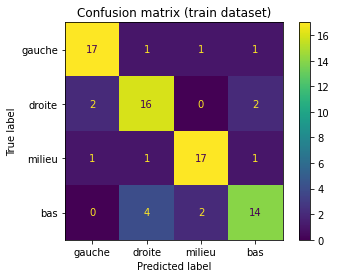

In [27]:
cm = confusion_matrix(yTrain, ypred, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (train dataset)')
plt.show()

Ce ne pas de la triche de regarder les performances sur les données que nous avons utilisées pour construire le classifieur ?

### Evaluation de la classification

Pour évaluer de façon juste, on va utiliser des sons qui n'ont pas déjà servi à l'apprentissage. On va par exemple prendre les nb derniers de chaque classe.

In [28]:
lesMfccTest = np.empty(shape=(nb*len(classes), 13), dtype=float) 
verbose=False

i=0
for cl in classes:
    listSons = glob.glob(basedir+ '\\'+cl+"/*.wav")
    for s in listSons[-nb:]:
        if verbose:
            print("###",s,"###")
        (sig,rate) = librosa.load(s)
        mfcc_feat = librosa.feature.mfcc(sig,rate,n_mfcc=13)
        if verbose:
            print("MFCC: ", mfcc_feat.shape, "len : ", len(sig))
        lesMfccTest[i] = np.mean(mfcc_feat, axis=1)
        i += 1

if verbose:
    print("shape : ",lesMfccTest.shape)
    
xTest = scaler.transform(lesMfccTest)
yTest = []
for clNumber in range(len(classes)):
    yTest += [clNumber]*nb

In [29]:
predTest = logisticRegr.predict(xTest)
print("test F1 score = ", f1_score(yTest, predTest, average = 'micro'))
print("test accuracy score = ", accuracy_score(yTest, predTest))


test F1 score =  0.6625
test accuracy score =  0.6625


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

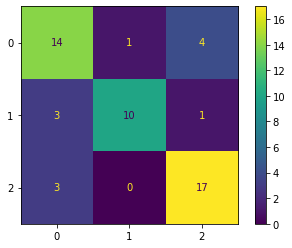

In [30]:
cm = confusion_matrix(yTest, predTest, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.set_title('Confusion matrix (test dataset)')
plt.show()

Essayez d'améliorer les résultats en augmentant le nombre de sons par classes ou en modifiant la représentation des sons.

Essayez également d'autres classes du jeu de données.

In [ ]:
#Tout convertir en wav